In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy import constants as cst
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
from numpy import interp
from scipy.integrate import trapezoid as trap
import seaborn as sns

# matplotlib globals
plt.rc('font',   size=16)          # controls default text sizes
plt.rc('axes',   titlesize=18)     # fontsize of the axes title
plt.rc('axes',   labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick',  labelsize=18)     # fontsize of the tick labels
plt.rc('ytick',  labelsize=18)     # fontsize of the tick labels
plt.rc('legend', fontsize=18)      # legend fontsize
plt.rc('figure', titlesize=18)     # fontsize of the figure title

## Auxiliary

In [2]:
def chirp(m1, m2):
    return (m1*m2)**(3/5) / (m1+m2)**(1/5)

def WD_radius(m):
    # Eggleton 1986 fit to Nauenberg for high m and ZS for low m. From 
    r = 0.0114*np.sqrt( (m/1.44)**(-2/3) - (m/1.44)**(2/3) ) * (1 + 3.5*(m/0.00057)**(-2/3) + 0.00057/m)**(-2/3)
    return r # solar radii

def a_min(m1, m2):
    # assume m2 < m1
    r1 = WD_radius(m1)
    r2 = WD_radius(m2)
    q = m2/m1
    ap_min = r1*(0.6 + q**(2/3) * np.log(1 + q**(-1/3)))/0.49
    as_min = r2*(0.6 + q**(-2/3) * np.log(1 + q**(1/3)))/0.49
    return max(ap_min, as_min) # in solar radii

def Kepler(m1, m2):
    nu = np.sqrt(cst.G * cst.M_sun*(m1+m2)/(4*np.pi**2*(a_min(m1, m2)* cst.R_sun)**3))
    return nu.value # Hz

def chirp(m1, m2):
    return (m1*m2)**(3/5) / (m1+m2)**(1/5)

def determine_nu_crit(m1, m2, time = 13.8):
    K = (96/5) * (2*np.pi)**(8/3) * (cst.G * chirp(m1,m2)*cst.M_sun)**(5/3) / cst.c**5
    return ((Kepler(m1, m2))**(-8/3) + 8*K.value*(time* 10**9 * 365.25 * 24 * 3600)/3)**(-3/8)

def K(M):
    return (96/5) * (2*np.pi)**(8/3) * (cst.G * M*cst.M_sun)**(5/3) / cst.c**5

def timespan(nu_1, nu_2, K):
    return 3*(nu_1**(-8/3) - nu_2**(-8/3))/(8*K)

def SFH(z):
    return 0.015*(1+z)**(2.7)/(1+((1+z)/2.9)**(5.6))  # solar mass / yr / Mpc^3 [Madau, Dickinson 2014]


# Paper

## Figures Gijs

/home/seppe/anaconda3/envs/data_analysis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


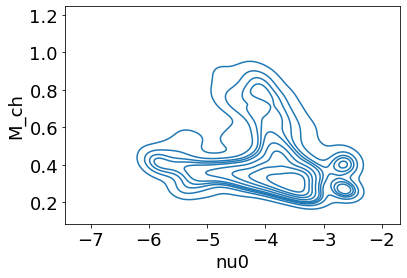

In [110]:
import seaborn as sns

initial = pd.read_csv("../Data/initials_final_2.txt", sep = ",", header=0)

sns.kdeplot(np.log10(2*initial["nu0"]), initial["M_ch"])

plt.show()


In [132]:
initial_check = initial[initial["nu0"] < 5e-6]
initial_check["nu0E-5"] = initial_check["nu0"]*1e5
can_be_seen = (timespan(initial_check["nu0"], 5e-6, initial_check["K"]) < 13.8e9 * 365.25*24*3600)
initial_check[can_be_seen]

/tmp/ipykernel_191564/2421959359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_check["nu0E-5"] = initial_check["nu0"]*1e5


,t0,a,m1,m2,nu0,M_ch,K,nu_max,nu0E-5
5072,4271.72,7.16147,0.54709,0.369196,0.000005,0.389747,7.653067e-07,0.009676,0.499063


## Time integration

First create an array of z bins corresponding to equally spaced time intervals.

In [10]:
T0 = cosmo.lookback_time(8)
N_t = 20
T_range = np.linspace(0, T0.value, 2*N_t+1)

T_list = np.array([T_range[2*i+1] for i in range(N_t)])
T_bins = np.array([T_range[2*i] for i in range(N_t+1)])

dT = (T_list[1] - T_list[0])

z_list = []
z_bins = []
for time in T_list:
    z_list.append(z_at_value(cosmo.lookback_time, time * u.Gyr).value)
for time in T_bins[1:]:
    z_bins.append(z_at_value(cosmo.lookback_time, time * u.Gyr).value)

z_bins[1::2]


[0.09758672307007864,
 0.21091904631006503,
 0.3452407606933971,
 0.5087529585432726,
 0.7150816948999171,
 0.9887695004832725,
 1.379361867336969,
 2.0060292692907256,
 3.2599403089559402,
 8.00000002576731]

### Stacked bar chart: Equal time bins

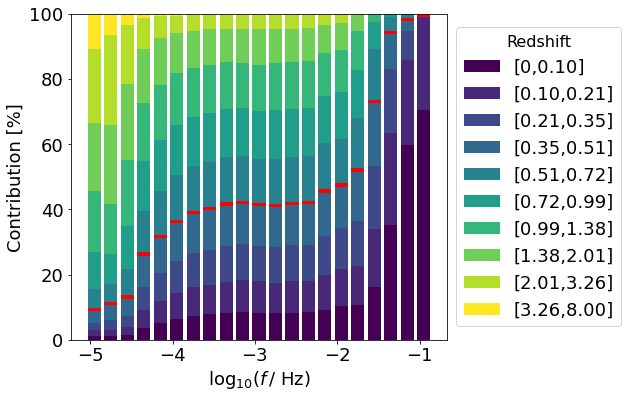

In [11]:
SFH = 1
N = 50
N_t = 20
SAVE = False

data1 = pd.read_csv(f"../Output/GWBs/SFH{SFH}_{N}_{N_t}_T_contr_final.txt", sep = ",")
data2 = pd.read_csv(f"../Output/GWBs/SFH{SFH}_{N}_{N_t}_T_contr_birth_final.txt", sep = ",")
data3 = pd.read_csv(f"../Output/GWBs/SFH{SFH}_{N}_{N_t}_T_contr_merge_final.txt", sep = ",")


f_range = np.logspace(-5, 0, 2*N+1, base = 10)
f_plot = np.log10(np.array([f_range[2*i+1] for i in range(N)]))
z_list = data1.z
colors = plt.cm.get_cmap('viridis', N_t//2)
new_data = pd.DataFrame({"z":z_list})

# Calculate the percentage contribution of the redshift bins
for i in range(N):
    new_data[f"prop_f_{i}"] = 99* (data1[f"freq_{i}"]+data2[f"freq_{i}"]+data3[f"freq_{i}"]) / (data1[f"freq_{i}"].sum()+data2[f"freq_{i}"].sum()+data3[f"freq_{i}"].sum())
new_data.drop("z", inplace=True, axis = 1)

fig, ax = plt.subplots(1, 1, figsize = (9,6))

if N == 25:

    width = (f_plot[2]-f_plot[1])

    ax.bar(f_plot, new_data.iloc[0] + new_data.iloc[1], 
        color = colors(0), label = f"[0,{z_bins[1]:.2f}]", width=0.8*width)
    sum = new_data.iloc[0] + new_data.iloc[1]

elif N==50:

    width = 2*(f_plot[2]-f_plot[1])

    ax.bar(f_plot[::2], new_data.iloc[0].values[::2] + new_data.iloc[1].values[::2], 
        color = colors(0), label = f"[0,{z_bins[1]:.2f}]", width=0.8*width)
    sum = new_data.iloc[0].values[::2] + new_data.iloc[1].values[::2]

else:
    print(f"Not correctly implemented yet for N = {N}.")

draw_line = False
prev_z_bin = z_bins[1]

for i, z in enumerate(z_bins[3::2]):

    if N == 25:
        props = new_data.iloc[2*i+2] + new_data.iloc[2*i+3]
        ax.bar(f_plot, props, bottom=sum, color = colors(i+1), label = f"[{prev_z_bin:.2f},{z:.2f}]", width=0.8*width)

    elif N == 50:
        props = new_data.iloc[2*i+2].values[::2] + new_data.iloc[2*i+3].values[::2]
        ax.bar(f_plot[::2], props, bottom=sum, color = colors(i+1), label = f"[{prev_z_bin:.2f},{z:.2f}]", width=0.8*width)
    
    else: 
        break

    sum = sum + props
    prev_z_bin = z
    if (z >= 0.46) and draw_line == False:
        draw_line = True

        if N == 25:
            ax.bar(f_plot, np.ones_like(props), bottom=sum, color = "red", width=0.8*width)
        elif N == 50:
            ax.bar(f_plot[::2], np.ones_like(props), bottom=sum, color = "red", width=0.8*width)

        sum = sum + np.ones_like(props)



ax.set_xlabel(r"$\log_{10} (f \,/$ Hz)")
ax.set_ylabel("Contribution [%]")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = "Redshift")

#plt.tight_layout()
# ax.set_xlim(-4.25, -0.85)

if SAVE:
    fig.savefig(f"../Output/Figures/z_contr_{N}_{N_t}_SFH{SFH}_T.png")

plt.show()


## Numbers of systems

The number of systems is determined in the main code and stored in the columns "freq_i_num". Such a column stores the number of BWDs in the corresponding frequency bin, for each z bin.

In [3]:
def Summary(N, N_z, tag, TIME = False):

    if TIME:
        label = "T"
    else:
        label = "z"

    data1b = pd.read_csv(f"../Output/GWBs/SFH1_{N}_{N_z}_{label}_contr_{tag}.txt")
    data2b = pd.read_csv(f"../Output/GWBs/SFH1_{N}_{N_z}_{label}_contr_birth_{tag}.txt")
    data3b = pd.read_csv(f"../Output/GWBs/SFH1_{N}_{N_z}_{label}_contr_merge_{tag}.txt")

    totals1b = []
    totals2b = []
    totals3b = []

    for n in range(N):
        totals1b.append(np.sum(data1b[f"freq_{n}_num"]))
        totals2b.append(np.sum(data2b[f"freq_{n}_num"]))
        totals3b.append(np.sum(data3b[f"freq_{n}_num"]))

    print(f"\n{tag}, {N} bins:\n")

    print(f"Total number of systems in bulk: {np.sum(np.array(totals1b)):.5E}")
    print(f"Total number of systems in birth bins: {np.sum(np.array(totals2b)):.5E}")
    print(f"Total number of systems in merge bins: {np.sum(np.array(totals3b)):.5E}")
    print(f"Total number of systems in non-bulk bins: {np.sum(np.array(totals2b)) + np.sum(np.array(totals3b)):.5E}")

    print(f"\nTOTAL: {np.sum(totals1b) + np.sum(totals2b) + np.sum(totals3b):.5E}")        

In [4]:
for n in [25, 50]:
    Summary(n, 20, "check", TIME=True)

Summary(50, 20,"final")


check, 25 bins:

Total number of systems in bulk: 4.16715E+16
Total number of systems in birth bins: 1.49734E+17
Total number of systems in merge bins: 2.06431E+16
Total number of systems in non-bulk bins: 1.70377E+17

TOTAL: 2.12048E+17

check, 50 bins:

Total number of systems in bulk: 6.39075E+16
Total number of systems in birth bins: 1.15711E+17
Total number of systems in merge bins: 2.50194E+16
Total number of systems in non-bulk bins: 1.40730E+17

TOTAL: 2.04638E+17

final, 50 bins:

Total number of systems in bulk: 6.40352E+16
Total number of systems in birth bins: 1.15576E+17
Total number of systems in merge bins: 2.51468E+16
Total number of systems in non-bulk bins: 1.40723E+17

TOTAL: 2.04758E+17


In [5]:
for n in [25, 50, 100]:
    Summary(n, 20, "type4")


type4, 25 bins:

Total number of systems in bulk: 4.17821E+16
Total number of systems in birth bins: 1.50402E+17
Total number of systems in merge bins: 2.12354E+16
Total number of systems in non-bulk bins: 1.71637E+17

TOTAL: 2.13419E+17

type4, 50 bins:

Total number of systems in bulk: 6.40868E+16
Total number of systems in birth bins: 1.16044E+17
Total number of systems in merge bins: 2.52714E+16
Total number of systems in non-bulk bins: 1.41315E+17

TOTAL: 2.05402E+17

type4, 100 bins:

Total number of systems in bulk: 8.84278E+16
Total number of systems in birth bins: 8.33086E+16
Total number of systems in merge bins: 2.62633E+16
Total number of systems in non-bulk bins: 1.09572E+17

TOTAL: 1.98000E+17


In [6]:
for n in [200, 300]:
    Summary(n, 20, "type4")


type4, 200 bins:

Total number of systems in bulk: 1.12008E+17
Total number of systems in birth bins: 5.59914E+16
Total number of systems in merge bins: 2.37777E+16
Total number of systems in non-bulk bins: 7.97692E+16

TOTAL: 1.91777E+17

type4, 300 bins:

Total number of systems in bulk: 1.24645E+17
Total number of systems in birth bins: 4.27839E+16
Total number of systems in merge bins: 2.12379E+16
Total number of systems in non-bulk bins: 6.40218E+16

TOTAL: 1.88667E+17


In [12]:
tag1 = "final"
N1 = 50
N_z1 = 20

data1 = pd.read_csv(f"../Output/GWBs/SFH1_{N1}_{N_z1}_z_contr_{tag1}.txt")
data2 = pd.read_csv(f"../Output/GWBs/SFH1_{N1}_{N_z1}_z_contr_birth_{tag1}.txt")
data3 = pd.read_csv(f"../Output/GWBs/SFH1_{N1}_{N_z1}_z_contr_merge_{tag1}.txt")

totals1 = []
totals2 = []
totals3= []

for n in range(N1):
    totals1.append(np.sum(data1[f"freq_{n}_num"]))
    totals2.append(np.sum(data2[f"freq_{n}_num"]))
    totals3.append(np.sum(data3[f"freq_{n}_num"]))

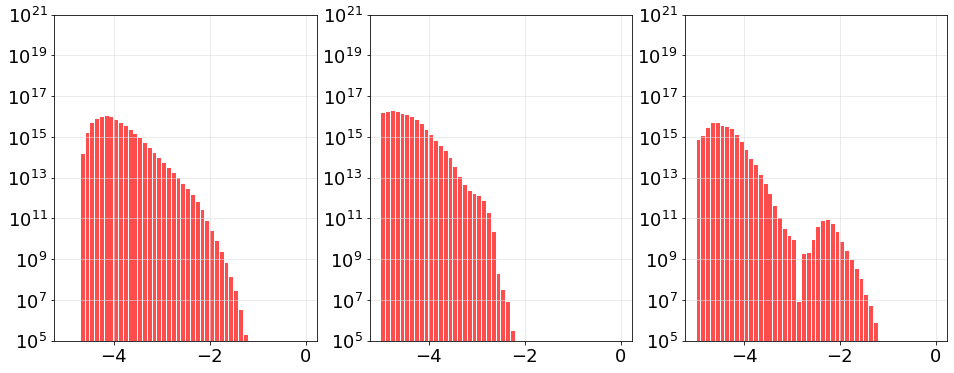

In [13]:
SAVE_FIG = False

f_range = np.logspace(-5, 0, 2*N1+1, base = 10)
f_plot = np.log10(np.array([f_range[2*i+1] for i in range(N1)]))

fig, ax = plt.subplots(1, 3, figsize = (16,6))

width = (f_plot[2]-f_plot[1])

# ax[0].bar(f_plot[::2], np.array(totals1), color = "red", width=0.8*width, alpha = 0.7)
ax[0].bar(f_plot, np.array(totals1), color = "red", width=0.8*width, alpha = 0.7)
ax[0].grid(color = "gainsboro", alpha=  0.7)
ax[0].set_yscale('log')
ax[0].set_ylim(10**5, 1e21)

ax[1].bar(f_plot, np.array(totals2), color = "red", width=0.8*width, alpha = 0.7)
ax[1].grid(color = "gainsboro", alpha=  0.7)
ax[1].set_yscale('log')
ax[1].set_ylim(10**5, 1e21)

ax[2].bar(f_plot, np.array(totals3), color = "red", width=0.8*width, alpha = 0.7)
ax[2].grid(color = "gainsboro", alpha=  0.7)
ax[2].set_yscale('log')
ax[2].set_ylim(10**5, 1e21)

if SAVE_FIG:
    fig.savefig("../Output/Figures/number_BWDs_comp_50.png", dpi = 1000)

plt.show()


## Number of systems: z distribution

In [55]:
def z_Summary(N, N_z, tag, SAVE_FIG = False):
    data1b = pd.read_csv(f"../Output/GWBs/SFH1_{N}_{N_z}_z_contr_{tag}.txt")
    data2b = pd.read_csv(f"../Output/GWBs/SFH1_{N}_{N_z}_z_contr_birth_{tag}.txt")
    data3b = pd.read_csv(f"../Output/GWBs/SFH1_{N}_{N_z}_z_contr_merge_{tag}.txt")

    totals1b = []
    totals2b = []
    totals3b = []

    for z in data1b["z"]:
        row1 = data1b[data1b["z"] == z]
        row2 = data2b[data2b["z"] == z]
        row3 = data3b[data3b["z"] == z]
        sum1, sum2, sum3 = 0, 0, 0
        for n in range(N):
            sum1 += row1[f"freq_{n}_num"].iloc[0]
            sum2 += row2[f"freq_{n}_num"].iloc[0]
            sum3 += row3[f"freq_{n}_num"].iloc[0]
        totals1b.append(sum1)
        totals2b.append(sum2)
        totals3b.append(sum3)

    fig, ax = plt.subplots(1, 3, figsize = (16,6))

    width = (8 / N_z)

    ax[0].bar(data1b["z"], np.array(totals1b), color = "red", width=0.8*width, alpha = 0.7)
    ax[0].grid(color = "gainsboro", alpha=  0.7)
    ax[0].set_yscale('log')
    ax[0].set_ylim(10**5, 1e21)

    ax[1].bar(data2b["z"], np.array(totals2b), color = "red", width=0.8*width, alpha = 0.7)
    ax[1].grid(color = "gainsboro", alpha=  0.7)
    ax[1].set_yscale('log')
    ax[1].set_ylim(10**5, 1e21)

    ax[2].bar(data3b["z"], np.array(totals3b), color = "red", width=0.8*width, alpha = 0.7)
    ax[2].grid(color = "gainsboro", alpha=  0.7)
    ax[2].set_yscale('log')
    ax[2].set_ylim(10**5, 1e21)

    if SAVE_FIG:
        fig.savefig("../Output/Figures/number_BWDs_comp_50.png", dpi = 1000)

    plt.show()


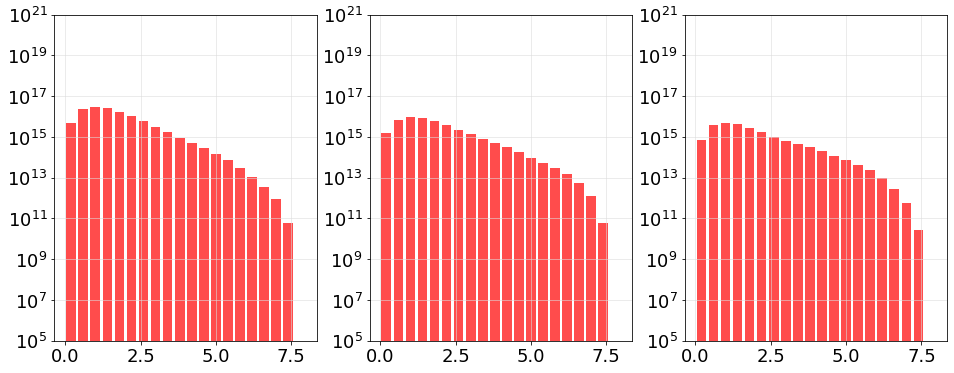

In [56]:
z_Summary(300, 20, "type4")

## Combination plot

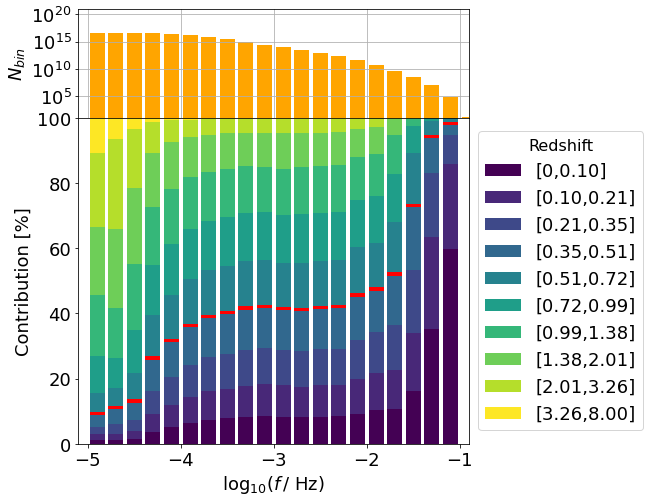

In [27]:
SAVE_FIG = True

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (7,8), sharex=True, gridspec_kw={'height_ratios': [1, 3]})

if N1 == 25:
    width = (f_plot[2]-f_plot[1])
    ax1.bar(f_plot, np.array(totals1) + np.array(totals2)+np.array(totals3), color = "orange", width=0.8*width)

elif N1 == 50:
    width = 2*(f_plot[2]-f_plot[1])
    ax1.bar(f_plot[::2]+0.05, np.array(totals1[::2]) + np.array(totals2[::2])+np.array(totals3[::2])
                        + np.array(totals1[1::2]) + np.array(totals2[1::2])+np.array(totals3[1::2]), color = "orange", width=0.8*width)

ax1.grid()
ax1.set_yscale('log')
ax1.set_ylim(10**1, 1e21)
ax1.set_ylabel(r"$N_{bin}$")
ax1.set_xlim(-5.1, -0.9)

if N1 == 25:

    ax2.bar(f_plot, new_data.iloc[0] + new_data.iloc[1], 
        color = colors(0), label = f"[0,{z_bins[1]:.2f}]", width=0.8*width)
    sum = new_data.iloc[0] + new_data.iloc[1]

elif N1==50:

    ax2.bar(f_plot[:-10:2]+0.05, new_data.iloc[0].values[:-10:2] + new_data.iloc[1].values[:-10:2], 
        color = colors(0), label = f"[0,{z_bins[1]:.2f}]", width=0.8*width)
    sum = new_data.iloc[0].values[::2] + new_data.iloc[1].values[::2]

else:
    print(f"Not correctly implemented yet for N = {N1}.")

draw_line = False
prev_z_bin = z_bins[1]


for i, z in enumerate(z_bins[3::2]):

    if N1 == 25:
        props = new_data.iloc[2*i+2] + new_data.iloc[2*i+3]
        ax2.bar(f_plot, props, bottom=sum, color = colors(i+1), label = f"[{prev_z_bin:.2f},{z:.2f}]", width=0.8*width)

    elif N1 == 50:
        props = new_data.iloc[2*i+2].values[::2] + new_data.iloc[2*i+3].values[::2]
        ax2.bar(f_plot[:-10:2]+0.05, props[:-5], bottom=sum[:-5], color = colors(i+1), label = f"[{prev_z_bin:.2f},{z:.2f}]", width=0.8*width)
    
    else: 
        break

    sum = sum + props
    prev_z_bin = z
    if (z >= 0.46) and draw_line == False:
        draw_line = True

        if N1 == 25:
            ax2.bar(f_plot, np.ones_like(props), bottom=sum, color = "red", width=0.8*width)
        elif N1 == 50:
            ax2.bar(f_plot[:-10:2]+0.05, np.ones_like(props[-5]), bottom=sum[:-5], color = "red", width=0.8*width)

        sum = sum + np.ones_like(props)

ax2.set_xlabel(r"$\log_{10} (f \,/$ Hz)")
ax2.set_ylabel("Contribution [%]")
ax2.set_xlim(-5.1, -0.9)

box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width*0.75, box.height])

box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width*0.75, box.height])
# Put a legend to the right of the current axis
lgd = ax2.legend(loc='center left', bbox_to_anchor=(1., 0.5), title = "Redshift")
ax1.set_yticks([10.**5, 10.**10, 10.**15, 10.**20])
ax1.set_yticklabels([r"$10^{" +f"{i}" + r"}$" for i in [5, 10, 15, 20]])

# plt.tight_layout()

fig.subplots_adjust(hspace = 0)
if SAVE_FIG:
    fig.savefig("../Output/Figures/comb_plot.png", bbox_extra_artists=(lgd,), bbox_inches='tight', dpi = 1000)

plt.show()


## Final GWB

In [8]:
data = pd.read_csv(f"../Output/GWBs/SFH1_50_20_wmerge_final.txt")

np.interp(0.001, data.f, data.Om)

          f            Om
0  0.000011  1.253842e-15
1  0.000014  3.031065e-15
2  0.000018  7.237640e-15
3  0.000022  1.585945e-14
4  0.000028  2.869767e-14


5.684705228702792e-12